In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import sklearn
import os
import dill as pickle
from itertools import combinations
import random
import tensorflow as tf

from keras.models import Model, Input, Sequential, load_model
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, ZeroPadding2D, Dropout
from keras.optimizers import SGD,Adam
import keras.metrics
from keras.utils import plot_model
from src.models import history
from keras.callbacks import ModelCheckpoint

from src.data import process_audio
from src.data import display_audio
from src.data import process_audio_siam
from src.models import one_shot_learning
from src.data import process_audio_VGG16_features
from src.models import one_shot_learning_VGG16



Using TensorFlow backend.


In [5]:
keras.__version__

'2.2.5'

In [5]:
%load_ext autoreload
%autoreload 2

# Siamese_VGG16 model

In [4]:
# Load CNN base model - VGG16
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3)) # remove top dense layers
 
for layer in VGG16_model.layers:     # freeze convolutional layers 
    layer.trainable = False    
    
# VGG-like 1
x1 = VGG16_model.output
x1 = Flatten()(x1) 
encodings1 = Dense(4096, activation='sigmoid')(x1)

# VGG16 with dense layers replaced
VGG16_like_1 = Model(inputs=VGG16_model.input, outputs=encodings1, name='VGG16_like_1')
VGG16_like_1.compile(optimizer=Adam(lr = 0.00006), loss='binary_crossentropy')

# VGG-like 2    
x2 = VGG16_model.output
x2 = Flatten()(x2) 
encodings2 = Dense(4096, activation='sigmoid')(x2)

# VGG16 with dense layers replaced
VGG16_like_2 = Model(inputs=VGG16_model.input, outputs=encodings2, name='VGG16_like_2')
VGG16_like_2.compile(optimizer=Adam(lr = 0.00006), loss='binary_crossentropy')

# Define tensors for two input audios
input_shape1 = (224, 224, 3)
input_shape2 = (224, 224, 3)

left_input = Input(input_shape1)
right_input = Input(input_shape2)    

encoded_l = VGG16_like_1(left_input)
encoded_r = VGG16_like_2(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_model_3 = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_model_3.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


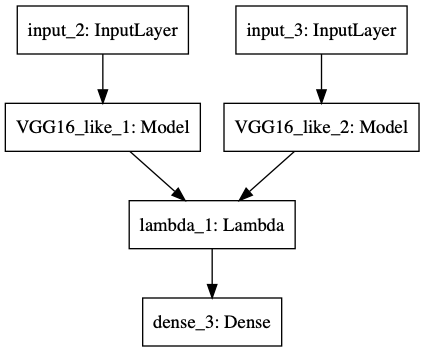

In [5]:
plot_model(siamese_model_3)

In [18]:
siamese_model_3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
VGG16_like_1 (Model)            (None, 4096)         117479232   input_2[0][0]                    
__________________________________________________________________________________________________
VGG16_like_2 (Model)            (None, 4096)         117479232   input_3[0][0]                    
____________________________________________________________________________________________

In [35]:
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Siamese with VGG16 embeddings - distinct weights

In [104]:
# Define tensors for two input audios
input_shape1 = (7, 7, 512)
input_shape2 = (7, 7, 512)

left_input = Input(input_shape1)
right_input = Input(input_shape2)    

# Left arm
left = Flatten()(left_input) 
encoded_l = Dense(4096, activation='sigmoid')(left)

# Right arm
right = Flatten()(right_input) 
encoded_r = Dense(4096, activation='sigmoid')(right)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_dist_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_dist_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

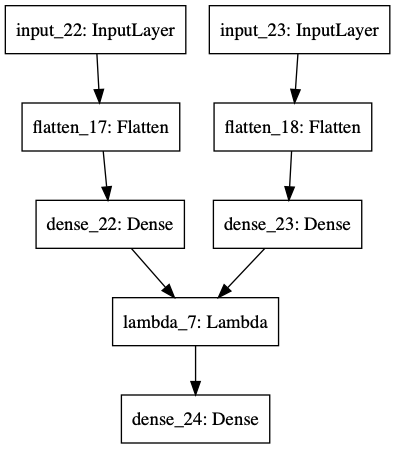

In [105]:
plot_model(siamese_dist_weights)

In [108]:
# Load dataframe:
data_10 = pickle.load(open('/Users/greenapple/project5/data/processed/data_10.pkl', 'rb')) # 10 speakers, 10 audios per speaker
data_10.shape

(100, 4)

In [109]:
# Reshape for the siamese model before modeling:
X_10, y_10, siamese_data_10 = process_audio_VGG16_features.dataframe_to_siamese_features(data_10)
X_10.shape, y_10.shape, siamese_data_10.shape

((9900, 2, 7, 7, 512), (9900,), (9900, 6))

In [110]:
# Data with the inputs from the same speaker (1) versus the inputs from two different speakers (0)  
siamese_data_10.siam_same_id.value_counts()

0    9000
1     900
Name: siam_same_id, dtype: int64

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 712s 90ms/step - loss: 0.3469 - acc: 0.9063 - val_loss: 0.4408 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.34692, saving model to history_siamese_dist_weights.h5
Epoch 2/5
7920/7920 [==============================] - 670s 85ms/step - loss: 0.3312 - acc: 0.9074 - val_loss: 0.4734 - val_acc: 0.9091

Epoch 00002: loss improved from 0.34692 to 0.33119, saving model to history_siamese_dist_weights.h5
Epoch 3/5
7920/7920 [==============================] - 655s 83ms/step - loss: 0.3166 - acc: 0.9090 - val_loss: 0.4690 - val_acc: 0.9091

Epoch 00003: loss improved from 0.33119 to 0.31657, saving model to history_siamese_dist_weights.h5
Epoch 4/5
7920/7920 [==============================] - 657s 83ms/step - loss: 0.3062 - acc: 0.9093 - val_loss: 0.4852 - val_acc: 0.9091

Epoch 00004: loss improved from 0.31657 to 0.30624, saving model to history_siamese_dist_weights.h5
Epoch 5/

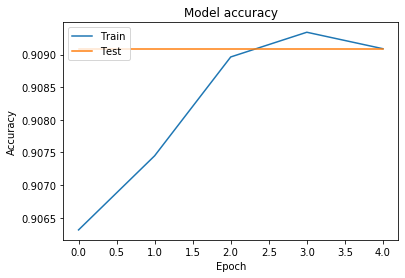

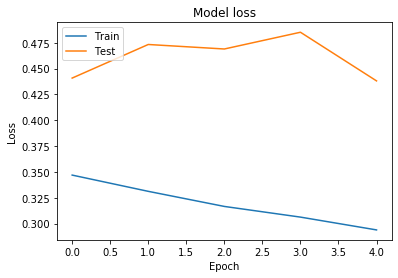

In [113]:
# Train and visualize 
checkpoint = ModelCheckpoint('history_siamese_dist_weights.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_dist_weights
history_siamese_dist_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_dist_weights.history['acc'])
plt.plot(history_siamese_dist_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [114]:
pickle.dump(
    history_siamese_dist_weights, 
    open('/Users/greenapple/project5/models/history_siamese_dist_weights.pkl', 'wb'))

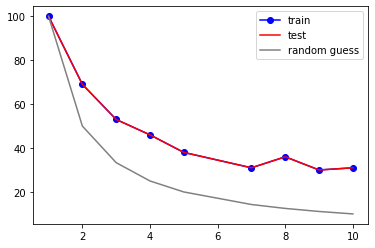

In [116]:
# One shot learning score:
model = siamese_dist_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', markerfacecolor='blue', label='train')
plt.plot(n_way_list, train_scores, color='red', label='test')
plt.plot(n_way_list, random_scores, color='gray', label='random guess')

plt.legend()    

# Siamese with VGG16 embeddings - same weights

In [117]:
# One dense layer
input_shape = (7, 7, 512)   

inputs = Input(input_shape)
output = Flatten()(inputs) 
encodings = Dense(4096, activation='sigmoid')(output)


one_dense = Model(inputs=inputs, outputs=encodings, name='one_dense')
one_dense.compile(optimizer=Adam(lr = 0.00006), 
                  loss='categorical_crossentropy')


# Define tensors for two input audios
input_shape = (7, 7, 512)

left_input = Input(input_shape)
right_input = Input(input_shape)    

encoded_l = one_dense(left_input)
encoded_r = one_dense(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_same_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_same_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

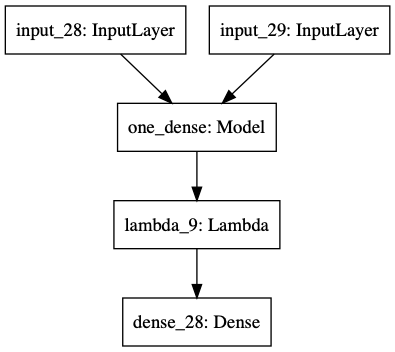

In [118]:
plot_model(siamese_same_weights)

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 537s 68ms/step - loss: 0.2391 - acc: 0.9080 - val_loss: 0.3532 - val_acc: 0.9091

Epoch 00001: loss improved from inf to 0.23908, saving model to history_siamese_same_weights.h5
Epoch 2/5
7920/7920 [==============================] - 492s 62ms/step - loss: 0.0669 - acc: 0.9832 - val_loss: 0.4799 - val_acc: 0.9091

Epoch 00002: loss improved from 0.23908 to 0.06690, saving model to history_siamese_same_weights.h5
Epoch 3/5
7920/7920 [==============================] - 480s 61ms/step - loss: 0.0167 - acc: 0.9999 - val_loss: 0.5914 - val_acc: 0.9091

Epoch 00003: loss improved from 0.06690 to 0.01667, saving model to history_siamese_same_weights.h5
Epoch 4/5
7920/7920 [==============================] - 494s 62ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.6686 - val_acc: 0.9091

Epoch 00004: loss improved from 0.01667 to 0.00678, saving model to history_siamese_same_weights.h5
Epoch 5/

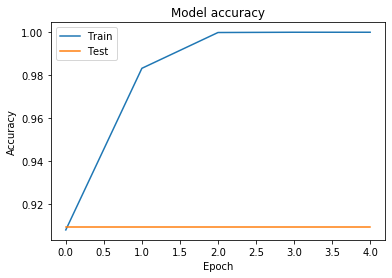

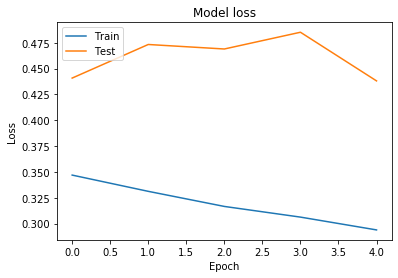

In [119]:
# Train and visualize 
checkpoint = ModelCheckpoint('history_siamese_same_weights.h5', 
                             monitor='loss', 
                             verbose=True,
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

model = siamese_same_weights
history_siamese_same_weights = model.fit([X_10[:, 0], X_10[:, 1]], 
                                         y_10, 
                                         validation_split=0.2, 
                                         epochs=5, 
                                         batch_size=32, 
                                         verbose=True,
                                         callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history_siamese_same_weights.history['acc'])
plt.plot(history_siamese_same_weights.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_siamese_dist_weights.history['loss'])
plt.plot(history_siamese_dist_weights.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

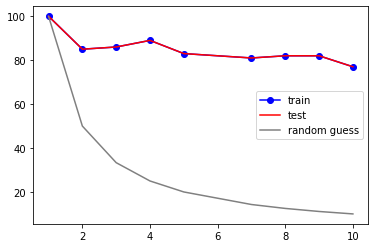

In [120]:
# One shot learning score:
model = siamese_same_weights
trials = 100
# n_way = 5
n_way_list = [1, 2, 3, 4, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', markerfacecolor='blue', label='train')
plt.plot(n_way_list, train_scores, color='red', label='test')
plt.plot(n_way_list, random_scores, color='gray', label='random guess')

plt.legend()    

# Siamese with VGG16 embeddings on 10 speakers

In [10]:
# Load dataframe:
data_10 = pickle.load(open('/Users/greenapple/project5/data/processed/data_10.pkl', 'rb')) # 10 speakers, 10 audios per speaker
data_10.shape

(100, 4)

In [11]:
# Reshape for the siamese model before modeling:
X_10, y_10, siamese_data_10 = process_audio_VGG16_features.dataframe_to_siamese_features(data_10)
X_10.shape, y_10.shape, siamese_data_10.shape

((9900, 2, 7, 7, 512), (9900,), (9900, 6))

In [12]:
# Data with the inputs from the same speaker (1) versus the inputs from two different speakers (0)  
siamese_data_10.siam_same_id.value_counts()

0    9000
1     900
Name: siam_same_id, dtype: int64

In [22]:
# Train:
siamese_model_4.fit([X_10[:, 0], X_10[:, 1]], y_10, 
                    epochs=1, 
                    verbose=True, 
                    batch_size=32, 
                    validation_split=0.2)

# Trained for 5 epochs (~15 min/epoch). The loss function no longer changes. Look at one shot learning next.

Train on 7920 samples, validate on 1980 samples
Epoch 1/1
7920/7920 [==============================] - 697s 88ms/step - loss: 0.3101 - acc: 0.9091 - val_loss: 0.3159 - val_acc: 0.9091


In [73]:
siamese_model_4.save('/Users/greenapple/project5/models/siamese_model_4_10_w_10_speakers.h5')

Train on 7920 samples, validate on 1980 samples
Epoch 1/5
7920/7920 [==============================] - 832s 105ms/step - loss: 0.3566 - acc: 0.9069 - val_loss: 0.3672 - val_acc: 0.9091
Epoch 2/5
7920/7920 [==============================] - 785s 99ms/step - loss: 0.3497 - acc: 0.9067 - val_loss: 0.3080 - val_acc: 0.9091
Epoch 3/5
7920/7920 [==============================] - 742s 94ms/step - loss: 0.3373 - acc: 0.9090 - val_loss: 0.3275 - val_acc: 0.9091
Epoch 4/5
7920/7920 [==============================] - 750s 95ms/step - loss: 0.3206 - acc: 0.9091 - val_loss: 0.3196 - val_acc: 0.9091
Epoch 5/5
7920/7920 [==============================] - 743s 94ms/step - loss: 0.3185 - acc: 0.9091 - val_loss: 0.3131 - val_acc: 0.9091


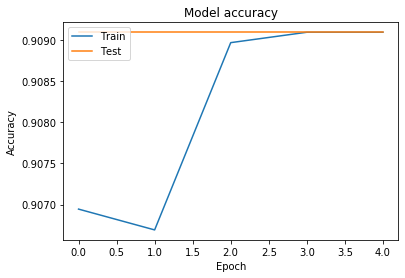

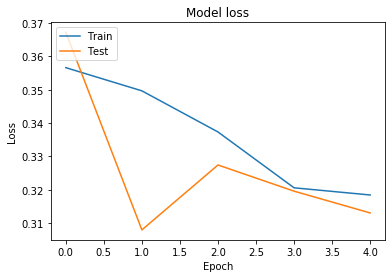

In [75]:
# Train and visualize the progress
model = siamese_model_5
history = model.fit([X_10[:, 0], X_10[:, 1]], y_10, validation_split=0.2, epochs=5, batch_size=32, verbose=True)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

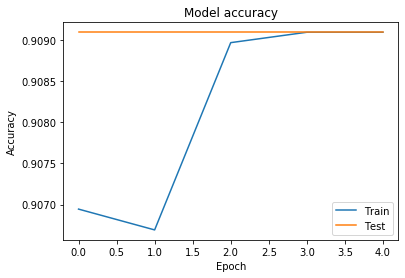

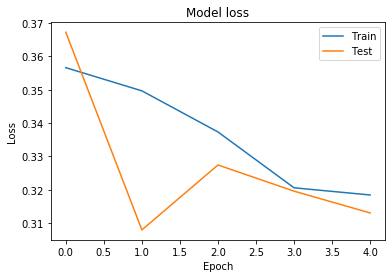

In [88]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
# plt.yticks(arange(0, 1.1, 0.1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [89]:
pickle.dump(history, open('/Users/greenapple/project5/models/history_siamese_model_5.pkl', 'wb'))

In [70]:
keras.callbacks.callbacks.History()

AttributeError: module 'keras.callbacks' has no attribute 'callbacks'

In [34]:
# Extract embeddings for the test set and organize them in a dataframe.
path = '/Users/greenapple/project5/data/raw/LibriSpeech/test-clean'
speaker_start = 0
speaker_stop = 10

test_data_10 = process_audio_VGG16_features.ten_audio_to_VGG16_features(path, speaker_start, speaker_stop)

Done with speaker 1, have 10 audio files
Done with speaker 2, have 10 audio files
Done with speaker 3, have 10 audio files
Done with speaker 4, have 10 audio files
Done with speaker 5, have 10 audio files
Done with speaker 6, have 10 audio files
Done with speaker 7, have 10 audio files
Done with speaker 8, have 10 audio files
Done with speaker 9, have 10 audio files
Done with speaker 10, have 10 audio files


In [48]:
# One shot learning score:
model = siamese_model_4
trials = 100
# n_way = 5
n_way_list = [1, 5, 7, 8, 9, 10]
train_scores = []
test_scores = []
num_speakers = 10

random_scores = [100/i for i in n_way_list]

speaker_data_train = data_10
speaker_data_test = test_data_10

for n_way in n_way_list:
    one_shot_train = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_train, n_way)
    one_shot_test = one_shot_learning_VGG16.one_shot_score(model, trials, speaker_data_test, n_way)
    
    train_scores.append(one_shot_train)
    test_scores.append(one_shot_test)

# Visualize one shot learning
plt.plot(n_way_list, train_scores, color='blue', marker='o', markerfacecolor='blue', label='train')
plt.plot(n_way_list, train_scores, color='red', label='test')
plt.plot(n_way_list, random_scores, color='gray', label='random guess')

plt.legend()    

In [49]:
train_scores, test_scores

([100.0, 100.0, 100.0, 100.0, 45.0, 51.0],
 [100.0, 100.0, 100.0, 100.0, 45.0, 51.0])

In [58]:
num_speakers = 10
random_scores = [100/i for i in n_way_list]

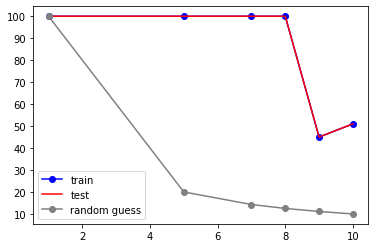

In [67]:
plt.yticks(range(0, 110, 10))
plt.plot(n_way_list, train_scores, color='blue', marker='o', markerfacecolor='blue', label='train')
plt.plot(n_way_list, train_scores, color='red', label='test')
plt.plot(n_way_list, random_scores, color='gray', marker='o', markerfacecolor='gray', label='random guess')

plt.legend();

# Siamese with VGG16 embeddings on 100 speakers

In [93]:
# Load dataframe. Keep 100 speakers, 10 audios per speaker:
train_data_900 = pickle.load(
    open('/Users/greenapple/project5/data/processed/data_900.pkl', 'rb')) 
train_data_100 = train_data_900[:100]

train_data_100.shape

(100, 4)

In [ ]:
siamese_data_100 = pd.DataFrame()
X_100 = np.array()
y_100 = 

In [ ]:
# Reshape for the siamese model before modeling:

for n in range(0, 100, 10):
    X_10, y_10, siamese_data_10 = process_audio_VGG16_features.dataframe_to_siamese_features(
        train_data_900[n:n+10]
    )
    # Train and visualize the progress
     model = siamese_model_5
     history = model.fit([X_10[:, 0], X_10[:, 1]], y_10, validation_split=0.2, epochs=5, batch_size=32, verbose=True)


In [ ]:
X_10.shape, y_10.shape, siamese_data_10.shape